RF-DETR train on custom dataset

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /mnt/d/Work/coding/vuzz/new/MIREA_7_semester_VT/rsppr/SAFE-MACS/model/rf-detr


In [ ]:
%pip install -q rfdetr==1.1.0

In [2]:
from roboflow import Roboflow

In [3]:
ROBOFLOW_API_KEY = ('pEbpvVmHCmE4sFlvI8Og')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("safemacsws").project("mppe-custom-set")
version = project.version(4)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [4]:
from rfdetr import RFDETRBase

In [5]:
model = RFDETRBase()

Loading pretrain weights


In [6]:
model.train(dataset_dir=dataset.location, epochs=20, batch_size=4, grad_accum_steps=2, lr=1e-4, early_stopping=True)

num_classes mismatch: model has 90 classes, but your dataset has 6 classes
reinitializing your detection head with 6 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=6, grad_accum_steps=2, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=20, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[2, 5, 8, 11], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=3, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads=1

fatal: not a git repository (or any of the parent directories): .git


Epoch: [0]  [  0/435]  eta: 0:13:19  lr: 0.000100  class_error: 76.54  loss: 15.7891 (15.7891)  loss_ce: 0.7755 (0.7755)  loss_bbox: 1.6175 (1.6175)  loss_giou: 1.4091 (1.4091)  loss_ce_0: 0.7007 (0.7007)  loss_bbox_0: 1.7766 (1.7766)  loss_giou_0: 1.5419 (1.5419)  loss_ce_1: 0.7487 (0.7487)  loss_bbox_1: 1.6367 (1.6367)  loss_giou_1: 1.4402 (1.4402)  loss_ce_enc: 0.6623 (0.6623)  loss_bbox_enc: 1.8705 (1.8705)  loss_giou_enc: 1.6094 (1.6094)  loss_ce_unscaled: 0.7755 (0.7755)  class_error_unscaled: 76.5385 (76.5385)  loss_bbox_unscaled: 0.3235 (0.3235)  loss_giou_unscaled: 0.7045 (0.7045)  cardinality_error_unscaled: 3749.5000 (3749.5000)  loss_ce_0_unscaled: 0.7007 (0.7007)  loss_bbox_0_unscaled: 0.3553 (0.3553)  loss_giou_0_unscaled: 0.7709 (0.7709)  cardinality_error_0_unscaled: 3171.2500 (3171.2500)  loss_ce_1_unscaled: 0.7487 (0.7487)  loss_bbox_1_unscaled: 0.3273 (0.3273)  loss_giou_1_unscaled: 0.7201 (0.7201)  cardinality_error_1_unscaled: 3494.5000 (3494.5000)  loss_ce_enc_uns

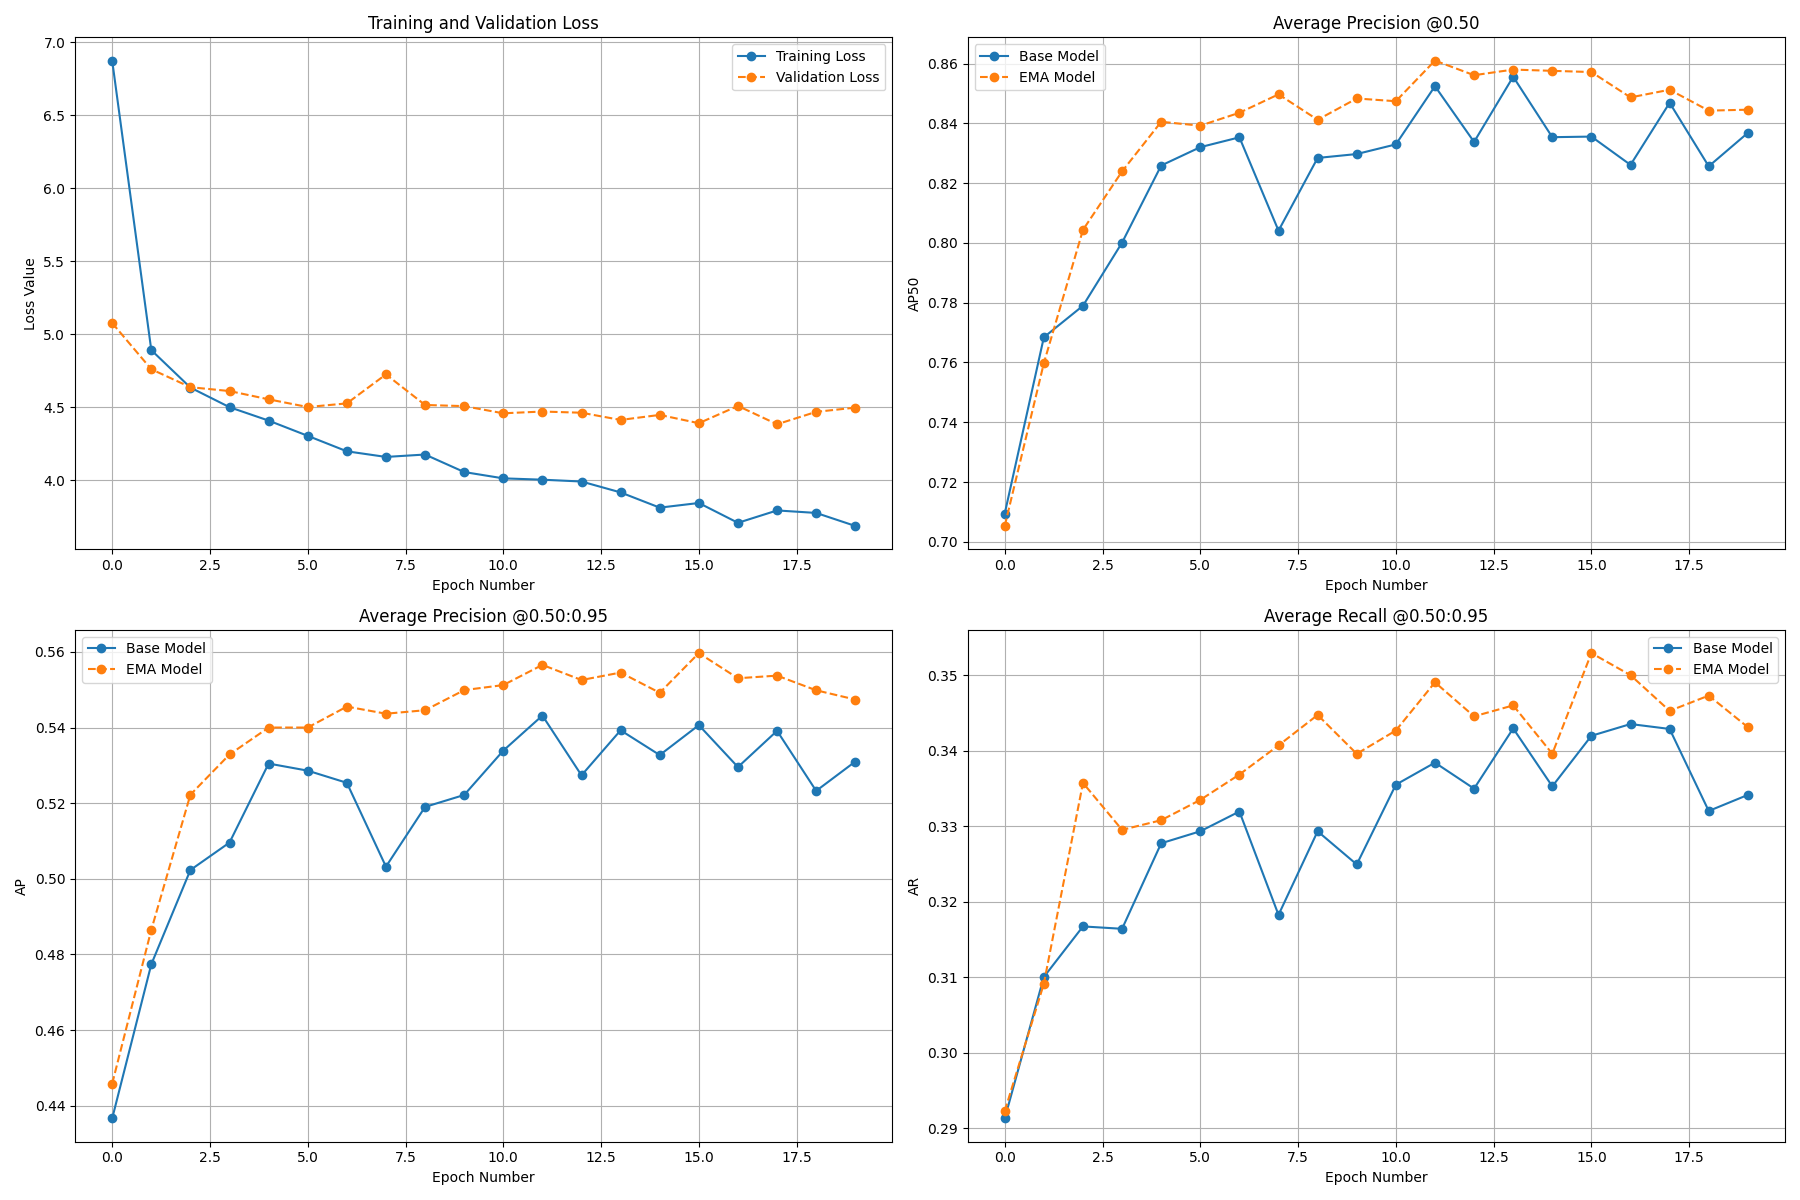

In [7]:
from PIL import Image

Image.open("./output/metrics_plot.png")

Inference

In [8]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

In [9]:
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

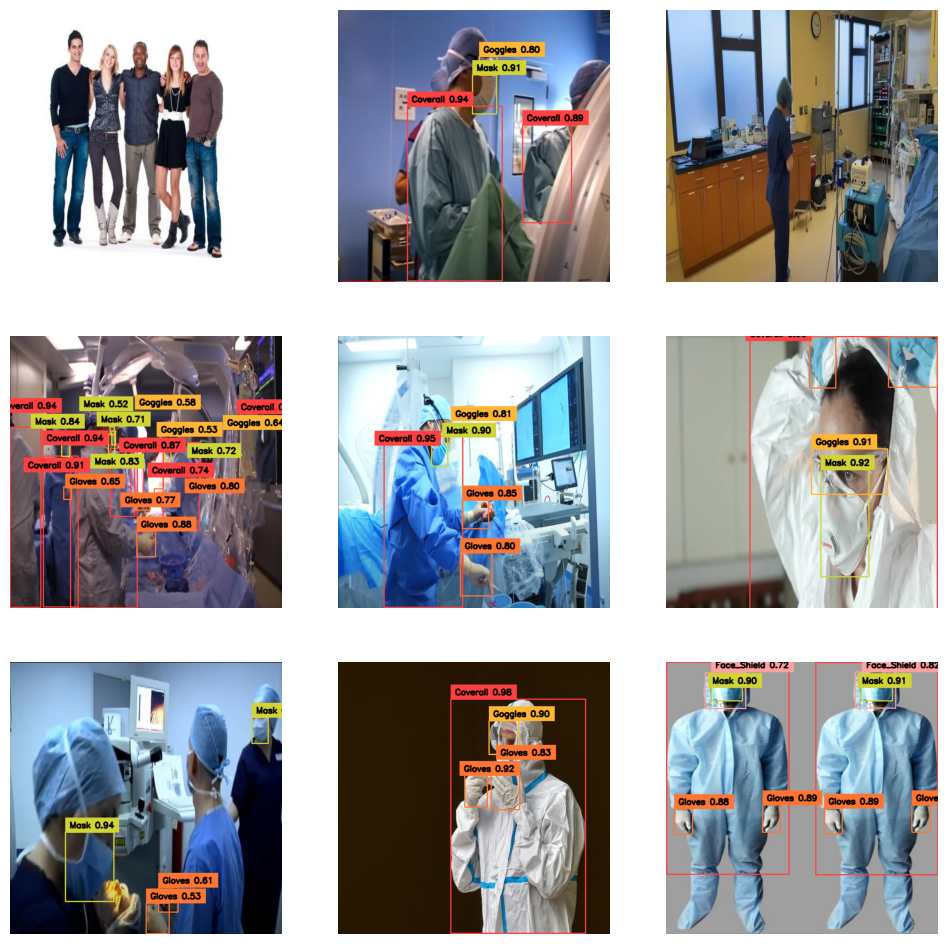

In [10]:
import supervision as sv
from rfdetr import RFDETRBase
from PIL import Image

detections_images = []

for i in range(9):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    bbox_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_thickness=thickness,
        smart_position=True)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(3, 3), size=(12, 12))

Evaluation

In [19]:
model = RFDETRBase(pretrain_weights='/mnt/d/Work/coding/vuzz/new/MIREA_7_semester_VT/rsppr/SAFE-MACS/model/rf-detr/output_ep5/checkpoint_best_regular.pth')

Loading pretrain weights


num_classes mismatch: pretrain weights has 5 classes, but your model has 90 classes
reinitializing detection head with 5 classes


In [11]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 287/287 [00:14<00:00, 19.40it/s]


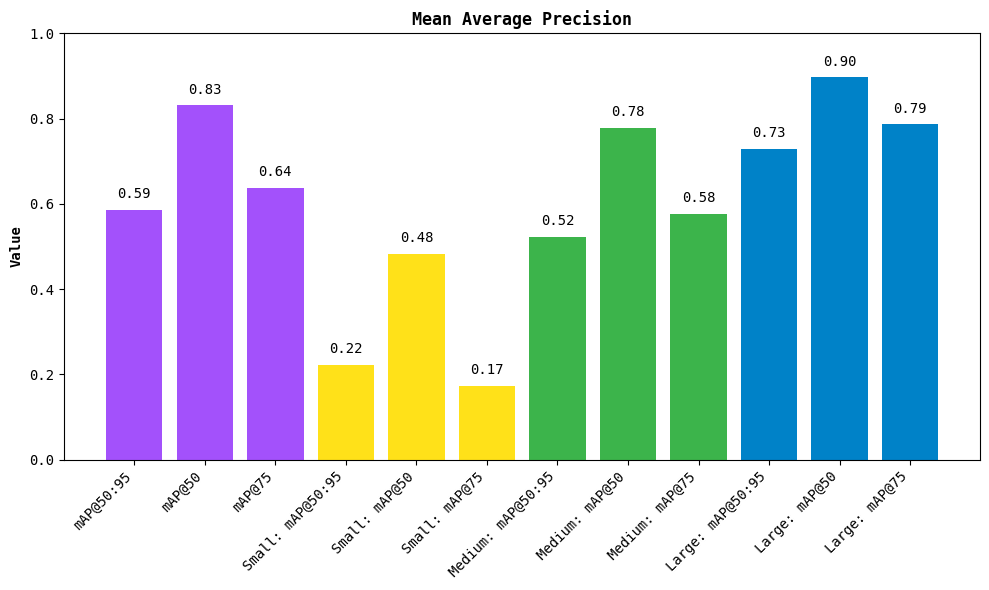

In [12]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

map_result.plot()

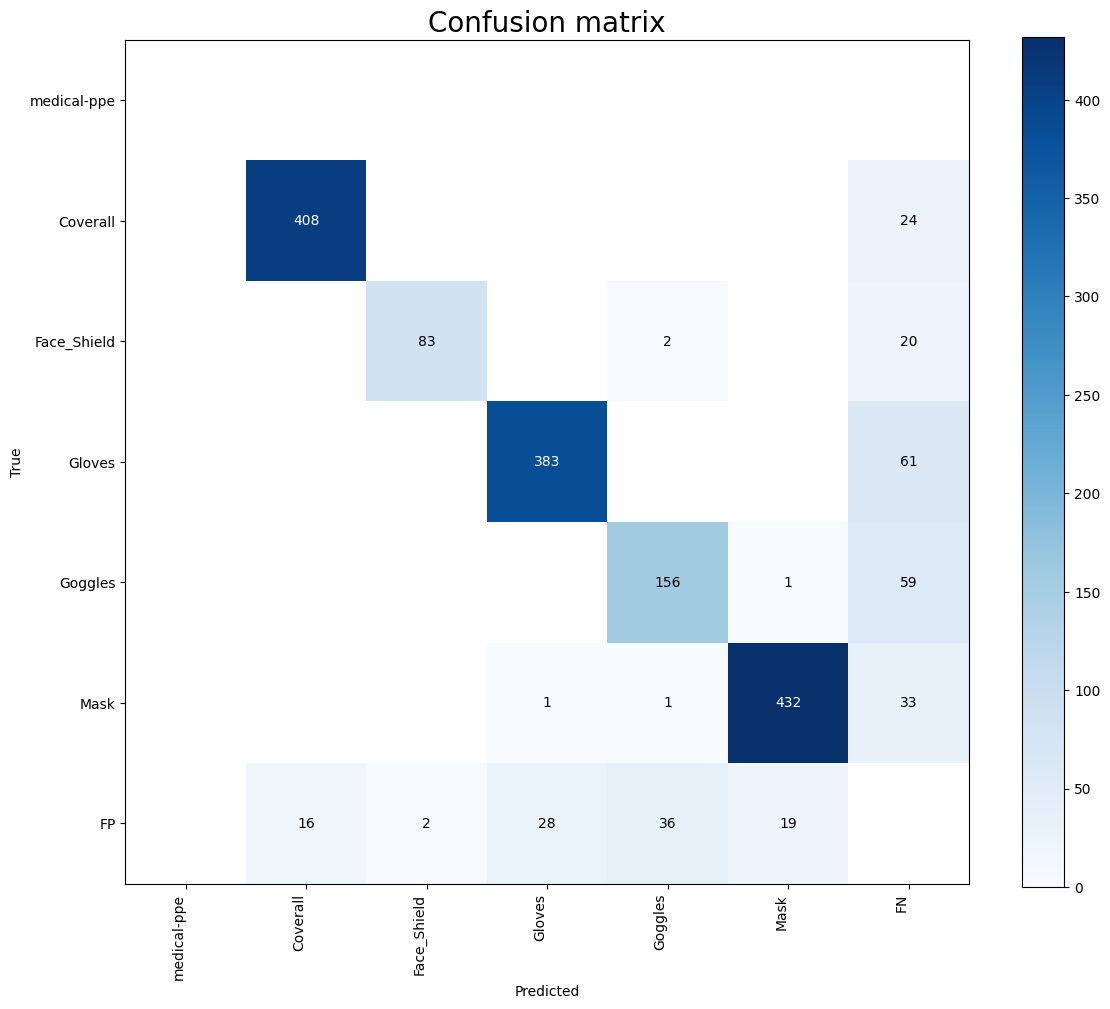

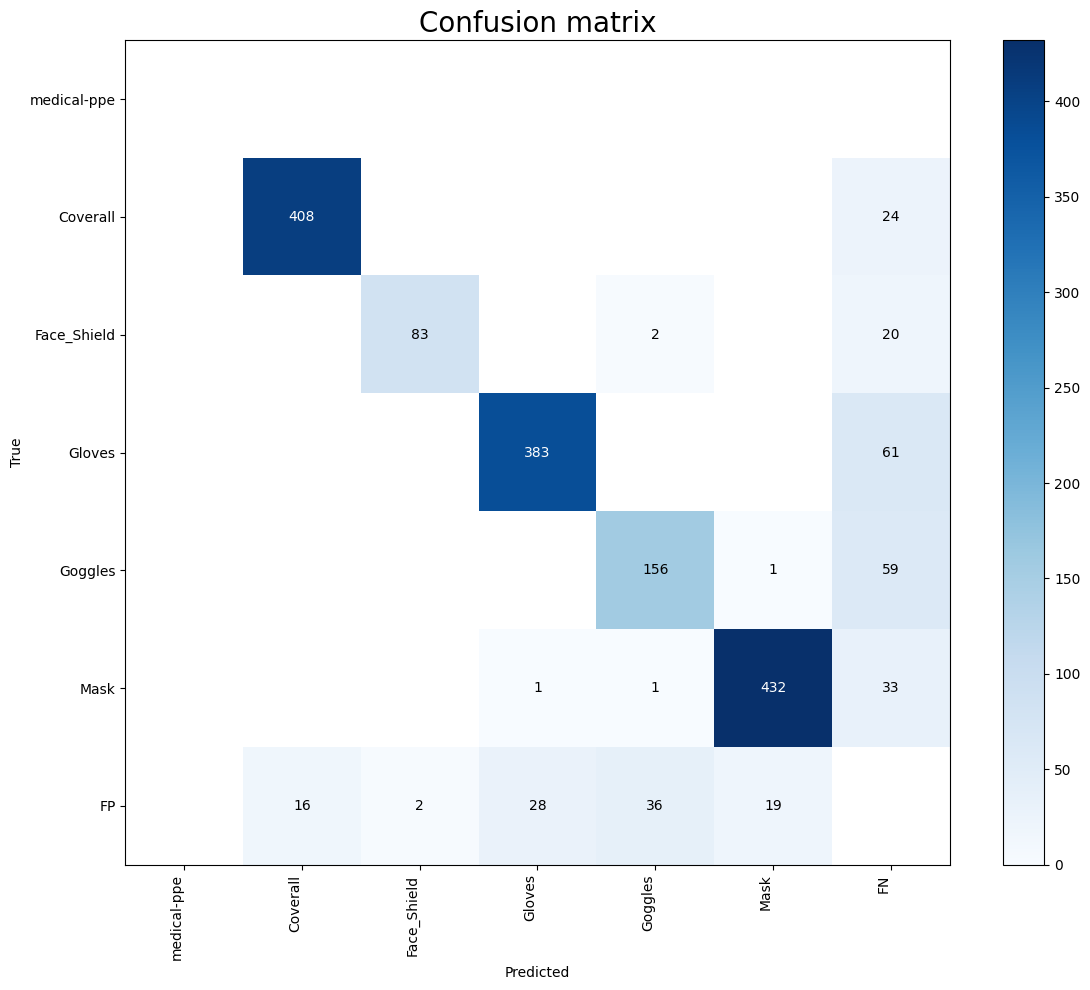

In [13]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds.classes
)

confusion_matrix.plot(title='Confusion matrix')

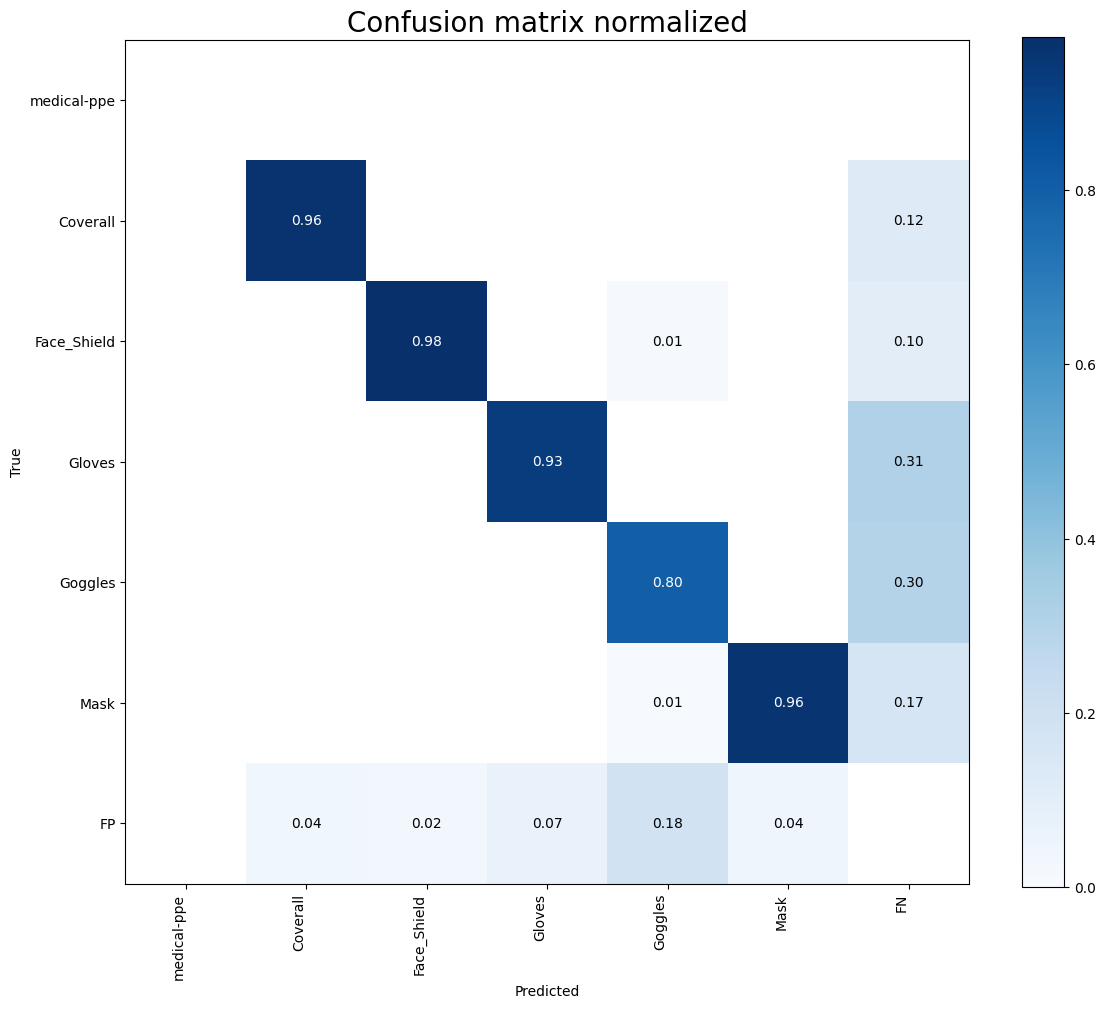

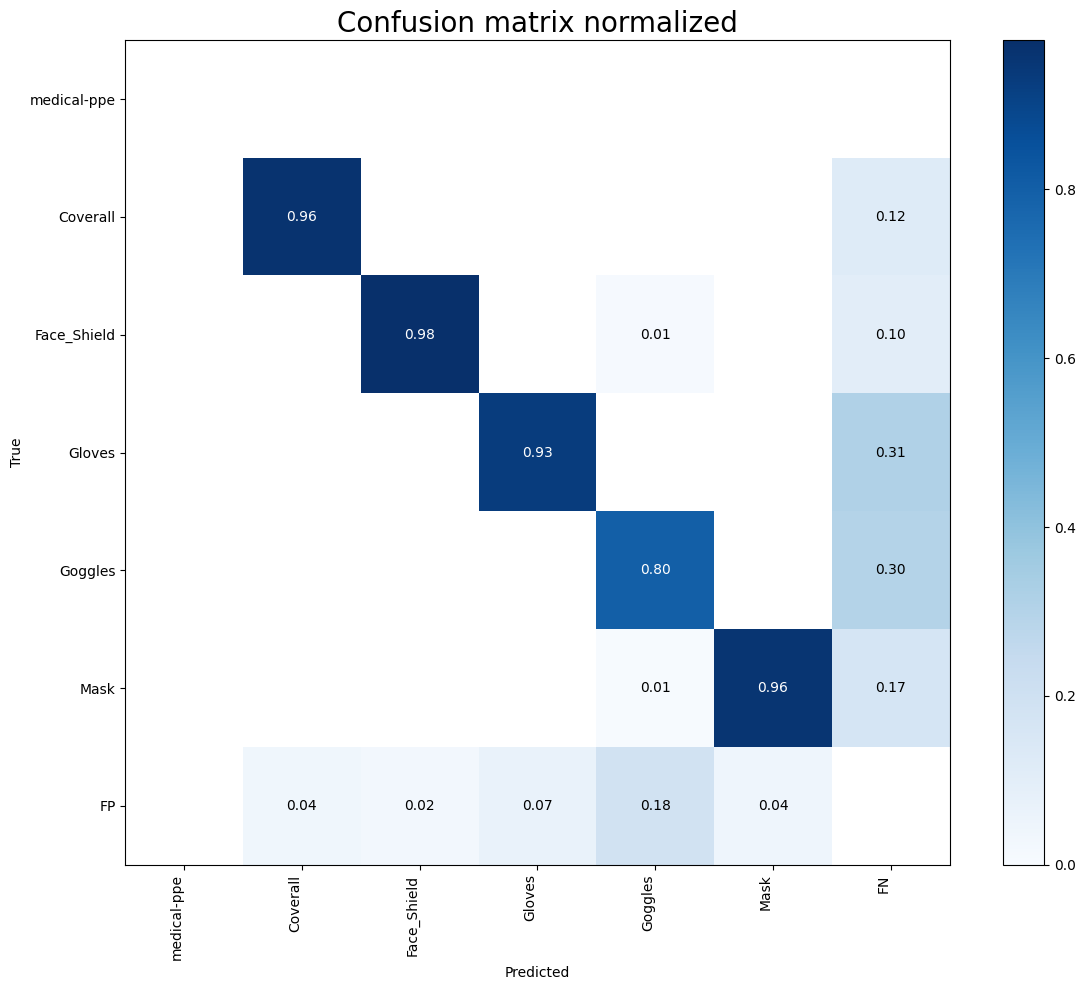

In [14]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds.classes
)

confusion_matrix.plot(normalize=True, title='Confusion matrix normalized')

In [15]:
from supervision.metrics import F1Score, Precision, Recall

In [16]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)
precision_metric = Precision().update(predictions, targets).compute()
recall_metric = Recall().update(predictions, targets).compute()
f1_metric = F1Score().update(predictions, targets).compute()

print(f"map50_95: {mean_average_precision.map50_95:.3f}")
print(f"map50: {mean_average_precision.map50:.3f}")
print(f"map75: {mean_average_precision.map75:.3f}")
print(f"Precision: {precision_metric.precision_at_50:.3f}")
print(f"Recall: {recall_metric.recall_at_50:.3f}")
print(f"F1 Score: {f1_metric.f1_50:.3f}")

map50_95: 0.676
map50: 0.901
map75: 0.739
Precision: 0.932
Recall: 0.879
F1 Score: 0.904


In [17]:
print(f"F1 Score: {f1_metric.f1_scores} at\nIoU thresholds: {f1_metric.iou_thresholds}")

F1 Score: [0.90406928 0.89157344 0.87164642 0.84480912 0.80976978 0.7499186
 0.67363385 0.55832797 0.38149247 0.16696978] at
IoU thresholds: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]


In [20]:
map50_per_class = [iou[0] for iou in mean_average_precision.per_class_ap50_95]

for class_name, map_val in zip(ds.classes[1:], map50_per_class):
    print(f'{class_name} - {map_val:.3f}')

Coverall - 0.967
Face_Shield - 0.888
Gloves - 0.896
Goggles - 0.801
Mask - 0.955
